In [1]:
import numpy as np
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io
# import shutils
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
%matplotlib inline
# import tensorflow
# import numpy as np
# import cv2
# import matplotlib
# from matplotlib import pyplot as plt
# %matplotlib inline

In [2]:
tf.version

<module 'tensorflow._api.v2.version' from 'C:\\Users\\empre\\anaconda3\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>

## 1. Preparando dataset

In [3]:
## Instanciando os métodos para detecção de rostos e olhos utilizando os algoritmos Haarcascade
face_cascade = cv2.CascadeClassifier('opencv/haarcascade/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('opencv/haarcascade/haarcascade_eye.xml')

In [4]:
path_to_data = "./dataset/" ## caminho das pastas com raw images
path_to_cr_data = "./dataset/cropped/" ## caminho das pastas com rostos identificados e recortados

In [5]:
import os
img_dirs = []
for entry in os.scandir(path_to_data): ## Percorrer as pastas com os nomes dos atores e adicionar numa lista o caminho de cada pasta
    if entry.is_dir():
        img_dirs.append(entry.path)
img_dirs

['./dataset/cropped', './dataset/dan-stulbach', './dataset/tom-hanks']

In [6]:
import shutil
if os.path.exists(path_to_cr_data): ## Se o caminho existe
     shutil.rmtree(path_to_cr_data) ## Delete-o
os.mkdir(path_to_cr_data) ## Cria o diretório "./dataset/cropped/"

In [7]:
## Função que recebe o caminho da imagem e retorna o rosto encontrado recortado se houver dois olhos no rosto.
## Está limitada a retornar apenas um rosto por imagem
faces = []
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path) ## ler imagem
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) ## converter para escala de cinza, pois haarcascade funciona melhor em escala de cinza
    faces = face_cascade.detectMultiScale(gray, 1.3, 5) ## detecta rosto e retorna coordenadas e tamanho do rosto
    for (x,y,w,h) in faces: ## laço para buscar olhos dentro do rosto encontrado
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2: ## Se detectar 2 olhos no rosto
            return roi_color
#             faces.append(roi_color)
            
#     return faces
#             

### 1.1 Recortando os rostos das imagens e salvando em pastas para cada ator

In [8]:
cropped_image_dirs = [] ## Caminho das pastas com rostos cortados de cada celebridade. Por exemplo "./dataset/cropped/tom-hanks"
celebrity_file_names_dict = {}

for img_dir in img_dirs: ## Para cada pasta de celebridade
    count = 1
    celebrity_name = img_dir.split('/')[-1] ## Extrai o nome da celebridade do caminho de cada pasta de celebridade
#     print(celebrity_name)
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir): ## Itera sobre todas as imagens dentro da pasta da celebridade
        roi_color = get_cropped_image_if_2_eyes(entry.path) ## Região do rosto cortada
        if roi_color is not None: ## Se a função retornar a imagem com o rosto cortarda
            cropped_folder = path_to_cr_data + celebrity_name ## Por exemplo "./dataset/cropped/neymar"
            if not os.path.exists(cropped_folder): ## Se o caminho acima ainda não existe
                os.makedirs(cropped_folder) ## Crie a pasta
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ", cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png" ## Por exemplo tom-hanks1.png
            cropped_file_path = cropped_folder + "/" + cropped_file_name ## Por exemplo "./dataset/cropped/tom-hanks/tom-hanks1.png"
            
            cv2.imwrite(cropped_file_path, roi_color) ## Grava imagem em disco
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path) ## Cria um dicionário com o caminho de todas as imagens na pasta "./dataset/cropped/"
            count += 1
                
# cropped_image_dirs

Generating cropped images in folder:  ./dataset/cropped/dan-stulbach
Generating cropped images in folder:  ./dataset/cropped/tom-hanks


### 1.2 Separando o dataset em diretórios de treinamento, teste e validação

In [9]:
print(os.getcwd())

C:\Users\empre\Desktop\final


In [13]:
## Organizar todo dataset com rostos recortados em diretórios de treinamento, teste e validação.

os.chdir(r'C:\Users\empre\Desktop\final\dataset\cropped')
if os.path.isdir('train/tom-hanks') is False:
    os.makedirs('train/tom-hanks')
    os.makedirs('train/dan-stulbach')
    os.makedirs('valid/tom-hanks')
    os.makedirs('valid/dan-stulbach')
    os.makedirs('test/tom-hanks')
    os.makedirs('test/dan-stulbach')
## Aqui temos um problema porque o número de imagens dos rostos para cada ator retornado pelo script acima não é igual,
## então não será um divisão igualitária. 

#for c in random.sample(glob.glob(r'C:\Users\empre\Desktop\final\dataset\cropped\dan-stulbach*'), 10): ## 500 imagens do Dan para treinamento
#    shutil.move(c, 'train/dan-stulbach')
#for c in random.sample(glob.glob(r'tom hanks*'), 5):
#    shutil.move(c, 'train/tom-hanks')
#for c in random.sample(glob.glob(r'dan stulbach*'), 10): ## 100 imagens do Dan para validação
#    shutil.move(c, 'valid/dan-stulbach')
#for c in random.sample(glob.glob(r'tom hanks*'), 5):
#    shutil.move(c, 'valid/tom-hanks')
#for c in random.sample(glob.glob(r'dan stulbach*'), 10): ## 50 imagens de gatos para teste
#    shutil.move(c, 'test/dan-stulbach')
#for c in random.sample(glob.glob(r'tom hanks*'), 2):
#    shutil.move(c, 'test/tom-hanks')

#os.chdir('../../')


In [14]:
train_path = 'train'
valid_path = 'valid'
test_path = 'test'

In [16]:
## Convertendo as imagens para um formato adequado que o modelo Sequential espera para fazer o treinamento. Formato de keras generator vgg16
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), classes=['tom-hanks', 'dan-stulbach'], batch_size=5)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), classes=['tom-hanks', 'dan-stulbach'], batch_size=5)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), classes=['tom-hanks', 'dan-stulbach'], batch_size=5, shuffle=False) ## É importante não é para embaralhar pq será útil na matriz de confusão

Found 110 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
Found 23 images belonging to 2 classes.


In [17]:
imgs, labels = next(train_batches) ## Pegando um único batch de imagens e labels do dataset de treinamento

In [18]:
## Funcão para plotar as imagens em grid com 1 linha e 10 colunas
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


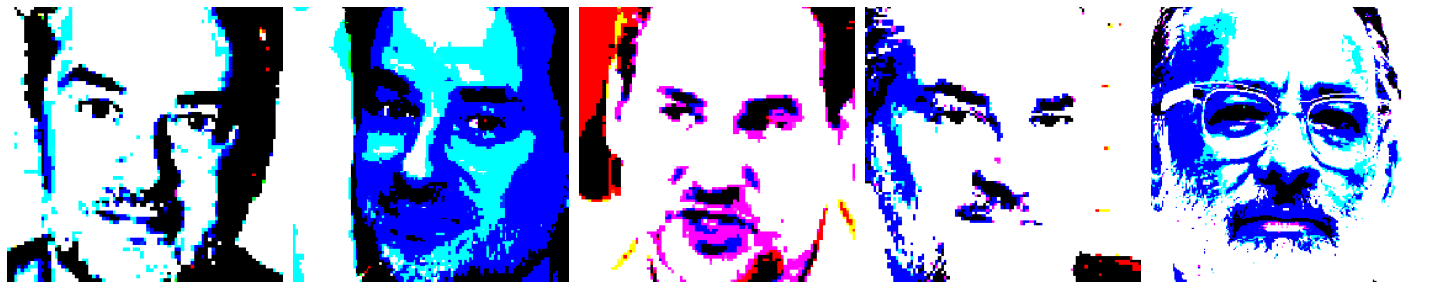

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [19]:
plotImages(imgs)
print(labels)
## As imagens vem com cores distorcidas devido ao preprocessamento para mudar seu formato

In [40]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)), ## padding='sama' a dimensão da imagem não reduz. input_shape é a primeira camada de entrada de dados
    MaxPool2D(pool_size=(2, 2), strides=2), ## maxpooling vai reduzir o tamanho da imagem por 2
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(), ## achatamento
    Dense(units=2, activation='softmax') ## dois nós/neurônios correspondendo cats and dogs. Softmax dará as probabilidades de cada classe
])

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
________________________________________________

In [42]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) ## loss também poderia ser binary_crossentropy já que são apenas duas classes

In [43]:
history = model.fit(x=train_batches, ## Nesse caso não precisou passar as lables Y, pois elas já se encontram dentro de X
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=8, # Valor escolhido por apresentar o pico da acurácia nos testes realizados
    verbose=2
)
## O modelo parece estar sofrendo de overfitting por conta de ir muito bem na acurácia, mas indo mal nas imagens de validação

Epoch 1/8
22/22 - 3s - loss: 52.6775 - accuracy: 0.5273 - val_loss: 32.8421 - val_accuracy: 0.5417
Epoch 2/8
22/22 - 3s - loss: 18.5848 - accuracy: 0.7545 - val_loss: 11.4773 - val_accuracy: 0.7083
Epoch 3/8
22/22 - 4s - loss: 2.1813 - accuracy: 0.9000 - val_loss: 11.3987 - val_accuracy: 0.6667
Epoch 4/8
22/22 - 3s - loss: 0.7559 - accuracy: 0.9455 - val_loss: 3.3549 - val_accuracy: 0.8750
Epoch 5/8
22/22 - 4s - loss: 4.9640e-04 - accuracy: 1.0000 - val_loss: 4.0983 - val_accuracy: 0.8333
Epoch 6/8
22/22 - 3s - loss: 0.0566 - accuracy: 0.9818 - val_loss: 5.1692 - val_accuracy: 0.8333
Epoch 7/8
22/22 - 3s - loss: 0.1359 - accuracy: 0.9909 - val_loss: 5.6819 - val_accuracy: 0.7917
Epoch 8/8
22/22 - 4s - loss: 0.0062 - accuracy: 1.0000 - val_loss: 4.0438 - val_accuracy: 0.8750


## 2. Prevendo

Text(0.5, 0, 'Epoch')

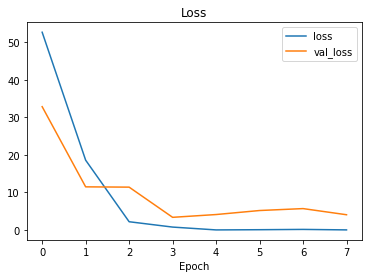

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

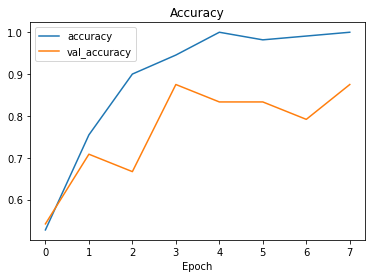

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')

In [29]:
test_imgs, test_labels = next(test_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


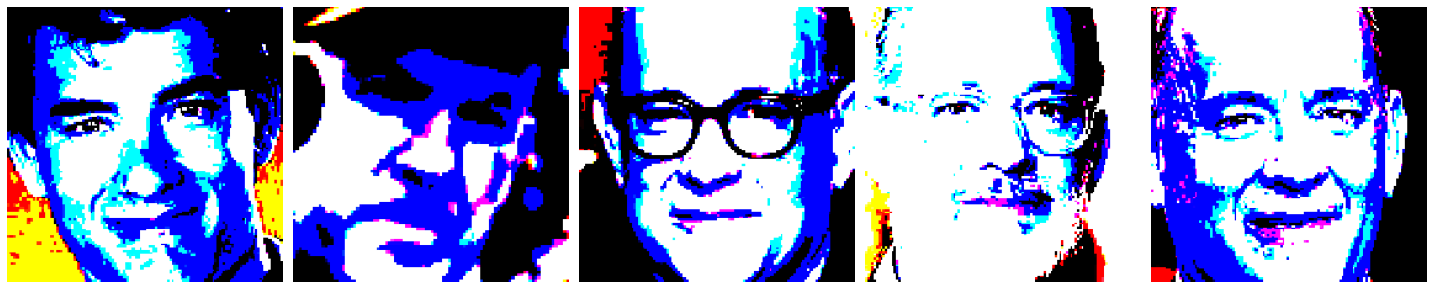

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [30]:
plotImages(test_imgs)
print(test_labels)

In [31]:
test_batches.classes ## labels do test set

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [32]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [33]:
np.round(predictions) ## Probabilidades em cada índice

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [34]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [35]:
## Função extraída dos docs scikitlearn
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
test_batches.class_indices

{'tom-hanks': 0, 'dan-stulbach': 1}

Confusion matrix, without normalization
[[ 8  0]
 [ 2 13]]


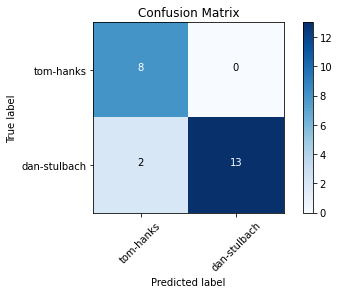

In [37]:
cm_plot_labels = ['tom-hanks','dan-stulbach']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## 3. Utilização de modelo pré-treinado

In [76]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [77]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [78]:
type(vgg16_model)

tensorflow.python.keras.engine.functional.Functional

In [79]:
model_pre = Sequential()
for layer in vgg16_model.layers[:-1]: # Adicionando todas as camadas do VGG16, exceto a última
    model_pre.add(layer)

In [80]:
for layer in model_pre.layers:
    layer.trainable = False

In [81]:
model_pre.add(Dense(units=2, activation='softmax'))

In [82]:
model_pre.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [83]:
model_pre.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [84]:
history_pre = model_pre.fit(x=train_batches,
          steps_per_epoch=len(train_batches),
          validation_data=valid_batches,
          validation_steps=len(valid_batches),
          epochs=10, # Número de épocas com melhor resultado, entre os testados
          verbose=2
)

Epoch 1/10
22/22 - 18s - loss: 0.4327 - accuracy: 0.8455 - val_loss: 0.5444 - val_accuracy: 0.7500
Epoch 2/10
22/22 - 18s - loss: 0.3370 - accuracy: 0.8727 - val_loss: 0.5018 - val_accuracy: 0.7917
Epoch 3/10
22/22 - 19s - loss: 0.2852 - accuracy: 0.9091 - val_loss: 0.4781 - val_accuracy: 0.7500
Epoch 4/10
22/22 - 19s - loss: 0.2485 - accuracy: 0.9091 - val_loss: 0.4585 - val_accuracy: 0.8333
Epoch 5/10
22/22 - 21s - loss: 0.2116 - accuracy: 0.9273 - val_loss: 0.4466 - val_accuracy: 0.7917
Epoch 6/10
22/22 - 20s - loss: 0.1931 - accuracy: 0.9364 - val_loss: 0.4372 - val_accuracy: 0.8333
Epoch 7/10
22/22 - 19s - loss: 0.1698 - accuracy: 0.9364 - val_loss: 0.4273 - val_accuracy: 0.8750
Epoch 8/10
22/22 - 19s - loss: 0.1501 - accuracy: 0.9545 - val_loss: 0.4164 - val_accuracy: 0.7917
Epoch 9/10
22/22 - 19s - loss: 0.1443 - accuracy: 0.9545 - val_loss: 0.4175 - val_accuracy: 0.7917
Epoch 10/10
22/22 - 18s - loss: 0.1225 - accuracy: 0.9727 - val_loss: 0.4139 - val_accuracy: 0.8750


Text(0.5, 0, 'Epoch')

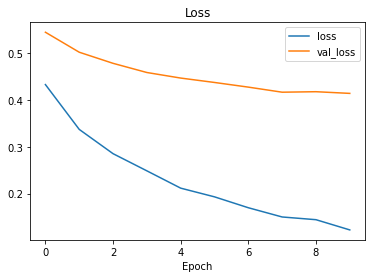

In [85]:
plt.plot(history_pre.history['loss'])
plt.plot(history_pre.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

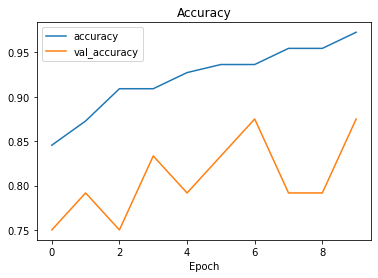

In [86]:
plt.plot(history_pre.history['accuracy'])
plt.plot(history_pre.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epoch')

In [87]:
predictions_pre = model_pre.predict(x=test_batches, steps=len(test_batches), verbose=0) # Usando os mesmos dados

Confusion matrix, without normalization
[[ 7  1]
 [ 1 14]]


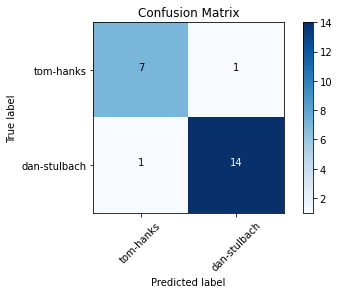

In [89]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions_pre, axis=-1))
cm_plot_labels = ['tom-hanks','dan-stulbach']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')